<a href="https://colab.research.google.com/github/mxn170019/Deep-Learning-Exercises/blob/master/NLP_Shakespeare_Text%20Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install tensorflow==2.1

In [0]:
import tensorflow
print(tensorflow.__version__)

2.1.0


In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [0]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()


--2020-03-19 19:35:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 2404:6800:4008:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-03-19 19:35:22 (160 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [0]:

corpus = data.lower().split("\n")


In [0]:
print(len(corpus))
print(len(corpus[0]))
print(type(corpus[0]))

2159
42
<class 'str'>


In [0]:
corpus[0:10]

['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,']

In [0]:
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(total_words)


3211


In [0]:
print(tokenizer.word_index)

In [0]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  print("printing token list")
  print(line,":",token_list,"\n")
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)
    print("printing input sequence list")
    print(input_sequences)

In [0]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

In [0]:
input_sequences[0:10]

[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517],
 [8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156]]

In [0]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))


In [0]:
input_sequences[0:10]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  34, 417],
       [  0,   0,   0,   0,   0,   0,   0,   0,  34, 417, 877],
       [  0,   0,   0,   0,   0,   0,   0,  34, 417, 877, 166],
       [  0,   0,   0,   0,   0,   0,  34, 417, 877, 166, 213],
       [  0,   0,   0,   0,   0,  34, 417, 877, 166, 213, 517],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   0,   0,   0,   8, 878, 134, 351, 102, 156]],
      dtype=int32)

In [0]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

# label = ku.to_categorical(label, num_classes=total_words)

In [0]:
predictors[0:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  34],
       [  0,   0,   0,   0,   0,   0,   0,   0,  34, 417],
       [  0,   0,   0,   0,   0,   0,   0,  34, 417, 877],
       [  0,   0,   0,   0,   0,   0,  34, 417, 877, 166],
       [  0,   0,   0,   0,   0,  34, 417, 877, 166, 213]], dtype=int32)

In [0]:
label[0:5]

array([417, 877, 166, 213, 517], dtype=int32)

In [0]:
label = ku.to_categorical(label, num_classes=total_words)

In [0]:
len(label[0])

3211

In [0]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

tensorflow.python.keras.layers.embeddings.Embedding

In [0]:
history = model.fit(predictors, label, epochs=100, verbose=1)

In [0]:
history.history

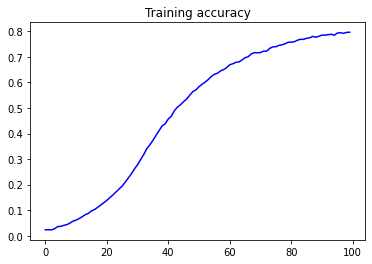

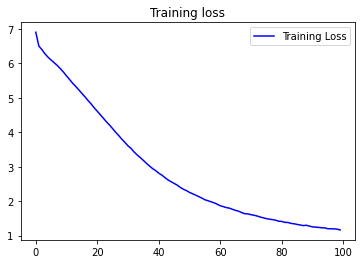

In [0]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [0]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope yet find that control thine skill rest confined doom still cold shade express'd buried skill skill sang behind foes hate twain hate ' up mine friend mine eyes thine bad they alone be you did lie so so you with this date now new hate prove thee thence foes hate twain hate prove thee long hate days seen best skill cold hour mine eyes lie so thee be mine eye doth steal departest thee new shown seem old young good skill go fresh last me things some delight skill hate ' assured invention ' did woe days out we play
